# Chapter 5: Multiple Regression

**The Many Variables: Revealing Spurious Associations**

## Goal

Fit **M5.3** with BOTH predictors:

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_A \cdot A_i + \beta_M \cdot M_i$$

**Key question:** What happens to βₘ when we control for Age?

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Prepare Data

In [3]:
# Load and standardize
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
waffle_data = pd.read_csv(url, sep=";")

divorce = waffle_data['Divorce'].values
marriage = waffle_data['Marriage'].values
age = waffle_data['MedianAgeMarriage'].values

D = (divorce - divorce.mean()) / divorce.std()
M = (marriage - marriage.mean()) / marriage.std()
A = (age - age.mean()) / age.std()

print(f"Sample size: {len(D)}")

Sample size: 50


---

## Model M5.3: Multiple Regression

### Model Specification

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_A \cdot A_i + \beta_M \cdot M_i$$

**Priors (same as before):**
$$\alpha \sim \text{Normal}(0, 0.2)$$
$$\beta_A \sim \text{Normal}(0, 0.5)$$
$$\beta_M \sim \text{Normal}(0, 0.5)$$
$$\sigma \sim \text{Exponential}(1)$$

### Interpretation of Coefficients

In multiple regression:
- **βₐ** = Effect of Age, **holding Marriage rate constant**
- **βₘ** = Effect of Marriage rate, **holding Age constant**

This is the key! Each coefficient represents the **unique** contribution of that predictor.

### Step 1: Prior Predictive Check

In [ ]:
# Prior predictive for multiple regression
n_prior = 50

alpha_prior = np.random.normal(0, 0.2, n_prior)
beta_A_prior = np.random.normal(0, 0.5, n_prior)
beta_M_prior = np.random.normal(0, 0.5, n_prior)

# Create a grid for visualization
A_grid = np.linspace(-2, 2, 30)
M_grid = np.linspace(-2, 2, 30)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Fix M=0, vary A
ax = axes[0]
for i in range(n_prior):
    mu = alpha_prior[i] + beta_A_prior[i] * A_grid + beta_M_prior[i] * 0
    ax.plot(A_grid, mu, 'k-', alpha=0.3, linewidth=1)
ax.set_xlabel('Age (M=0)', fontsize=11)
ax.set_ylabel('Divorce', fontsize=11)
ax.set_title('Prior: Effect of Age (holding M constant)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-3, 3)

# Plot 2: Fix A=0, vary M
ax = axes[1]
for i in range(n_prior):
    mu = alpha_prior[i] + beta_A_prior[i] * 0 + beta_M_prior[i] * M_grid
    ax.plot(M_grid, mu, 'k-', alpha=0.3, linewidth=1)
ax.set_xlabel('Marriage (A=0)', fontsize=11)
ax.set_ylabel('Divorce', fontsize=11)
ax.set_title('Prior: Effect of Marriage (holding A constant)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print("✓ Priors are reasonable and symmetric")

#### Marginal vs Joint Prior Checks

**What we just did above: Marginal prior checks**
- Vary one parameter at a time, fix others at their expected values (0)
- Shows isolated effect of each parameter
- Easier to interpret and debug individual priors

**What we'll do next: Joint prior predictive**
- All parameters vary simultaneously from their priors
- Include sigma noise to simulate actual observations
- Shows full range of predictions the model could generate before seeing data
- More realistic but harder to interpret

The joint check will be **wider/more variable** because all uncertainty sources combine!

In [ ]:
# Joint Prior Predictive: All parameters vary together
n_sims = 50

# Sample ALL priors simultaneously
alpha_sim = np.random.normal(0, 0.2, n_sims)
beta_A_sim = np.random.normal(0, 0.5, n_sims)
beta_M_sim = np.random.normal(0, 0.5, n_sims)
sigma_sim = np.random.exponential(1, n_sims)

# Create range for predictions
A_range = np.linspace(-2, 2, 50)
M_range = np.linspace(-2, 2, 50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions when M=0, A varies
ax = axes[0]
for i in range(n_sims):
    # Compute mu (mean prediction)
    mu = alpha_sim[i] + beta_A_sim[i] * A_range + beta_M_sim[i] * 0
    # Generate observations with noise
    y_sim = np.random.normal(mu, sigma_sim[i])
    ax.plot(A_range, y_sim, 'k-', alpha=0.2, linewidth=1)

ax.set_xlabel('Age (M=0)', fontsize=11)
ax.set_ylabel('Divorce', fontsize=11)
ax.set_title('Joint Prior Predictive: All parameters vary\n(Age effect, with observation noise)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-4, 4)

# Plot 2: Predictions when A=0, M varies
ax = axes[1]
for i in range(n_sims):
    mu = alpha_sim[i] + beta_A_sim[i] * 0 + beta_M_sim[i] * M_range
    y_sim = np.random.normal(mu, sigma_sim[i])
    ax.plot(M_range, y_sim, 'k-', alpha=0.2, linewidth=1)

ax.set_xlabel('Marriage (A=0)', fontsize=11)
ax.set_ylabel('Divorce', fontsize=11)
ax.set_title('Joint Prior Predictive: All parameters vary\n(Marriage effect, with observation noise)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

print("✓ Joint prior predictive complete")
print("  Notice: More variability than marginal checks due to:")
print("  • All parameters varying simultaneously")
print("  • Sigma adding observation noise")

### Step 2: Fit Model M5.3

In [5]:
def neg_log_posterior_m53(params):
    """
    M5.3: D ~ α + βA·A + βM·M
    
    Parameters: [alpha, beta_A, beta_M, log_sigma]
    """
    alpha = params[0]
    beta_A = params[1]
    beta_M = params[2]
    log_sigma = params[3]
    sigma = np.exp(log_sigma)
    
    # Linear model with BOTH predictors
    mu = alpha + beta_A * A + beta_M * M
    
    # Likelihood
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    
    # Priors
    log_prior_alpha = stats.norm.logpdf(alpha, loc=0, scale=0.2)
    log_prior_beta_A = stats.norm.logpdf(beta_A, loc=0, scale=0.5)
    log_prior_beta_M = stats.norm.logpdf(beta_M, loc=0, scale=0.5)
    log_prior_log_sigma = stats.expon.logpdf(sigma, scale=1)
    
    # Jacobian
    jacobian = log_sigma
    
    log_posterior = (log_lik + log_prior_alpha + log_prior_beta_A + 
                     log_prior_beta_M + log_prior_log_sigma + jacobian)
    
    return -log_posterior

# Fit
initial_params_m53 = [0.0, 0.0, 0.0, np.log(1.0)]
param_names_m53 = ['alpha', 'beta_A', 'beta_M', 'log_sigma']

print("Fitting M5.3: Divorce ~ Age + Marriage...")
m53 = quap(neg_log_posterior_m53, initial_params_m53, param_names_m53)
print("✓ Model fitted")

# Transform log_sigma to sigma
m53.transform_param('log_sigma', 'sigma', np.exp)
print("✓ Transformed log_sigma → sigma\n")

m53.summary()

Fitting M5.3: Divorce ~ Age + Marriage...
✓ Model fitted
✓ Registered transformation: log_sigma -> sigma
✓ Transformed log_sigma → sigma

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0214 seconds
Log posterior at MAP: -61.29

          mean    std  89%_lower  89%_upper
alpha   0.0007 0.0994    -0.1589     0.1578
beta_A -0.6130 0.1539    -0.8557    -0.3660
beta_M -0.0656 0.1520    -0.3068     0.1756
sigma   0.8056 0.0799     0.6840     0.9375


,mean,std,89%_lower,89%_upper
alpha,0.000715,0.099406,-0.158906,0.157765
beta_A,-0.613028,0.153874,-0.855737,-0.365998
beta_M,-0.065587,0.151985,-0.306800,0.175627
sigma,0.805586,0.079913,0.683984,0.937470


---

## The Big Reveal: Comparing All Three Models

Let's see how coefficients change across models!

In [6]:
# We need to refit M5.1 and M5.2 to have them available
# (In practice, you'd load these from previous notebook)

# Quick refit of M5.1
def neg_log_posterior_m51(params):
    alpha, beta_A, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_A * A
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_A, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m51 = quap(neg_log_posterior_m51, [0, 0, np.log(1)], ['alpha', 'beta_A', 'log_sigma'])
m51.transform_param('log_sigma', 'sigma', np.exp)

# Quick refit of M5.2
def neg_log_posterior_m52(params):
    alpha, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_M * M
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_M, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m52 = quap(neg_log_posterior_m52, [0, 0, np.log(1)], ['alpha', 'beta_M', 'log_sigma'])
m52.transform_param('log_sigma', 'sigma', np.exp)

print("✓ Refitted M5.1 and M5.2 for comparison (with transformations)")

✓ Registered transformation: log_sigma -> sigma
✓ Registered transformation: log_sigma -> sigma
✓ Refitted M5.1 and M5.2 for comparison (with transformations)


In [7]:
# Extract coefficients
coef_m51 = m51.coef()
coef_m52 = m52.coef()
coef_m53 = m53.coef()

# Create comparison table
comparison = pd.DataFrame({
    'M5.1 (Age only)': [
        f"{coef_m51['beta_A']:.3f}",
        "—"
    ],
    'M5.2 (Marriage only)': [
        "—",
        f"{coef_m52['beta_M']:.3f}"
    ],
    'M5.3 (Both)': [
        f"{coef_m53['beta_A']:.3f}",
        f"{coef_m53['beta_M']:.3f}"
    ]
}, index=['βA (Age)', 'βM (Marriage)'])

print("\n" + "="*70)
print("COEFFICIENT COMPARISON ACROSS MODELS")
print("="*70)
print(comparison)
print("="*70)


COEFFICIENT COMPARISON ACROSS MODELS
              M5.1 (Age only) M5.2 (Marriage only) M5.3 (Both)
βA (Age)               -0.568                    —      -0.613
βM (Marriage)               —                0.350      -0.066


### The Shocking Result!

**What happened to βₘ?**

Look at the table above:

**M5.2 (Marriage alone):** βₘ is POSITIVE and significant
- Higher marriage rate → Higher divorce

**M5.3 (Both predictors):** βₘ ≈ 0 (or even slightly negative!)
- Marriage rate effect DISAPPEARED!
- Or became much weaker

**M5.1 vs M5.3 (Age):** βₐ stays NEGATIVE and strong
- Age effect is REAL
- Persists even when controlling for marriage rate

### What Does This Mean?

**Marriage rate's association with divorce is SPURIOUS!**

It was confounded by Age:
1. Younger marriage age → Higher marriage rate
2. Younger marriage age → Higher divorce rate
3. Marriage rate APPEARS related to divorce
4. But it's only because both are caused by Age!

**Age is the real causal variable.**

---

## Visualize the Comparison

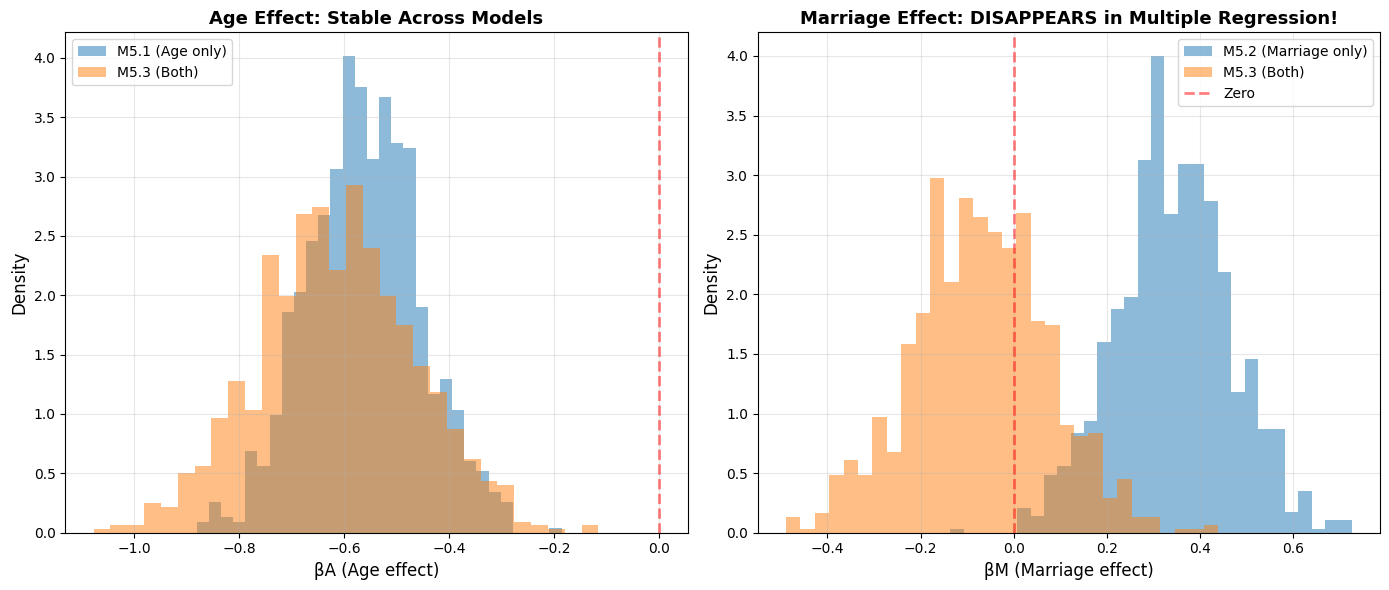

Key Observation:
• βA (Age): Remains strong and negative
• βM (Marriage): Collapses toward zero when Age is included
• This is the signature of a spurious association!


In [8]:
# Coefficient plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sample from posteriors
post_m51 = m51.sample(n=1000, seed=42)
post_m52 = m52.sample(n=1000, seed=42)
post_m53 = m53.sample(n=1000, seed=42)

# Plot 1: Beta_A comparison
ax = axes[0]
ax.hist(post_m51['beta_A'], bins=30, alpha=0.5, label='M5.1 (Age only)', density=True)
ax.hist(post_m53['beta_A'], bins=30, alpha=0.5, label='M5.3 (Both)', density=True)
ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel('βA (Age effect)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Age Effect: Stable Across Models', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Beta_M comparison
ax = axes[1]
ax.hist(post_m52['beta_M'], bins=30, alpha=0.5, label='M5.2 (Marriage only)', density=True)
ax.hist(post_m53['beta_M'], bins=30, alpha=0.5, label='M5.3 (Both)', density=True)
ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Zero')
ax.set_xlabel('βM (Marriage effect)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Marriage Effect: DISAPPEARS in Multiple Regression!', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observation:")
print("• βA (Age): Remains strong and negative")
print("• βM (Marriage): Collapses toward zero when Age is included")
print("• This is the signature of a spurious association!")

---

## Posterior Predictive Check for M5.3

Does the multiple regression model fit well?

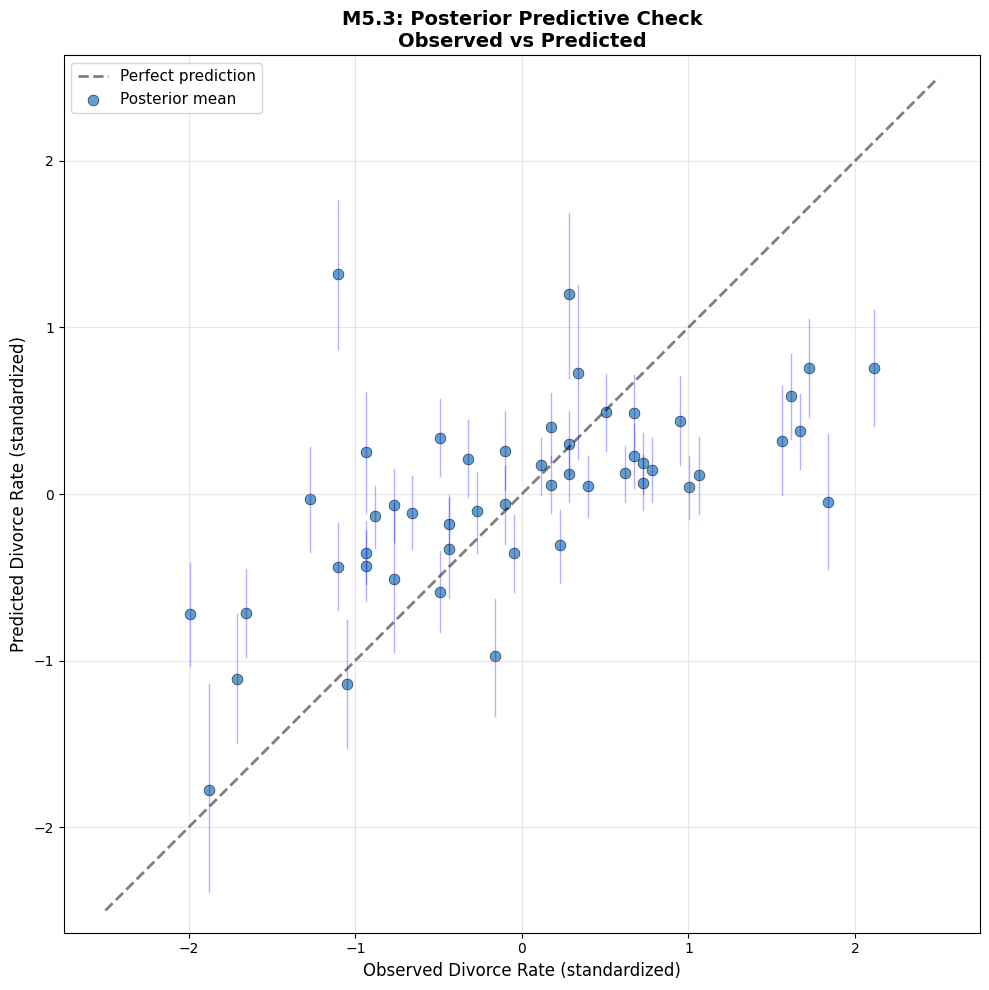

Model fit statistics:
  R² = 0.361
  Model explains 36.1% of variance


In [9]:
# Generate predictions from M5.3
post_m53 = m53.sample(n=1000, seed=42)

# Compute mu for observed data
alpha_samples = post_m53['alpha'].values
beta_A_samples = post_m53['beta_A'].values
beta_M_samples = post_m53['beta_M'].values
sigma_samples = post_m53['sigma'].values  # Now directly available!

mu_samples = (alpha_samples[:, None] + 
              beta_A_samples[:, None] * A[None, :] + 
              beta_M_samples[:, None] * M[None, :])

mu_mean = mu_samples.mean(axis=0)
mu_lower = np.percentile(mu_samples, 5.5, axis=0)
mu_upper = np.percentile(mu_samples, 94.5, axis=0)

# Plot predictions vs observed
plt.figure(figsize=(10, 10))

# Plot diagonal (perfect prediction line)
plt.plot([-2.5, 2.5], [-2.5, 2.5], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')

# Plot predictions with uncertainty
for i in range(len(D)):
    plt.plot([D[i], D[i]], [mu_lower[i], mu_upper[i]], 'b-', alpha=0.3, linewidth=1)

plt.scatter(D, mu_mean, s=60, alpha=0.7, edgecolor='black', linewidth=0.5, label='Posterior mean')

plt.xlabel('Observed Divorce Rate (standardized)', fontsize=12)
plt.ylabel('Predicted Divorce Rate (standardized)', fontsize=12)
plt.title('M5.3: Posterior Predictive Check\nObserved vs Predicted', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Compute R²
residuals = D - mu_mean
ss_res = np.sum(residuals**2)
ss_tot = np.sum((D - D.mean())**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"Model fit statistics:")
print(f"  R² = {r_squared:.3f}")
print(f"  Model explains {r_squared*100:.1f}% of variance")

---

## Summary: What We Learned

### The Three Models

**M5.1: D ~ A**
- βₐ strongly negative
- Age matters!

**M5.2: D ~ M**
- βₘ positive
- Marriage rate appears to matter

**M5.3: D ~ A + M**
- βₐ still strongly negative
- βₘ ≈ 0 (disappeared!)

### The Key Insight

**Marriage rate's effect on divorce is SPURIOUS**

It only appeared significant because:
1. Both marriage rate and divorce are caused by age
2. This creates a spurious correlation
3. When we control for age (include it in the model), the marriage effect vanishes

**This is confounding in action!**

### Causal Structure (Preview of DAGs)

```
Age → Marriage Rate
 ↓         ↓ (spurious)
Divorce ← (real)
```

- Age is a **confounder**
- Creates spurious association between M and D
- Multiple regression reveals the truth

### Why This Matters

**Simple correlation/regression can be misleading!**
- M and D are correlated
- But correlation ≠ causation
- Need multiple regression to disentangle effects

**This is the power of multiple regression:**
- Controls for confounding
- Reveals true causal relationships
- Essential for causal inference

### Next Steps

**Notebook 3: Residual and Counterfactual Plots**
- Visualize what each predictor adds
- Residual plots
- Counterfactual reasoning
- "What if" scenarios

---